# Group 3 Final Term Notebook

Members: Chen Gege, Lynette Cheryl Luth, Tammie Koh, Subhadhra Manikandan, Liu Yichuan, Li Xingqi

In [1]:
# repo imports
from main import run_backtest, plot_exposure, plot_drawdown, plot_vs_benchmark
import os, logging
import pandas as pd
import matplotlib.pyplot as plt


## 1. Strategy Description

1. Describe overall strategy - core concepts, enhanced features, trading logic
2. Describe parameters - hyperparameters (to be optimised), execution and risk controls, vol and position sizing

## 2. Backtesting (Out-of-sample testing)

1. Explain why we used out-of-sample testing vs in-sample testing or expanding-window testing
2. Explain the train_frac 

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] Train period: 2012-05-18 00:00:00 → 2016-03-10 00:00:00 (958 days)
[NOTIFY] Test  period: 2016-03-11 00:00:00 → 2019-12-30 00:00:00 (958 days)
[NOTIFY] Saved OOS returns → /Users/Student/Desktop/is4226/is4226-final/storage/returns_oos.csv
[NOTIFY] Saved OOS trades  → /Users/Student/Desktop/is4226/is4226-final/storage/trades_oos.csv
{'CAGR': 0.3119198515785464, 'Sharpe': np.float64(2.9667829116182793), 'MaxDrawdown': -0.08101004372123655, 'Calmar': 3.850384930687027}


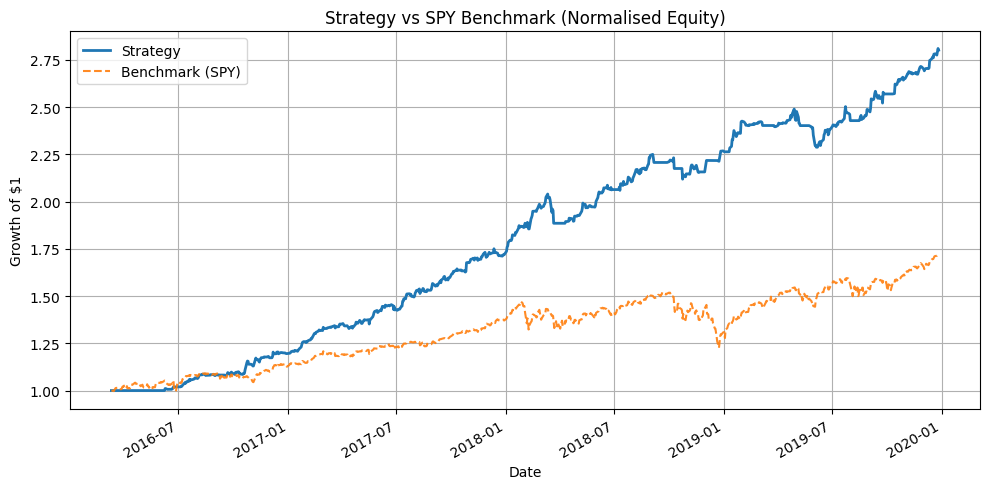

Gross cap respected (sum|weights| ≤ gross_cap).


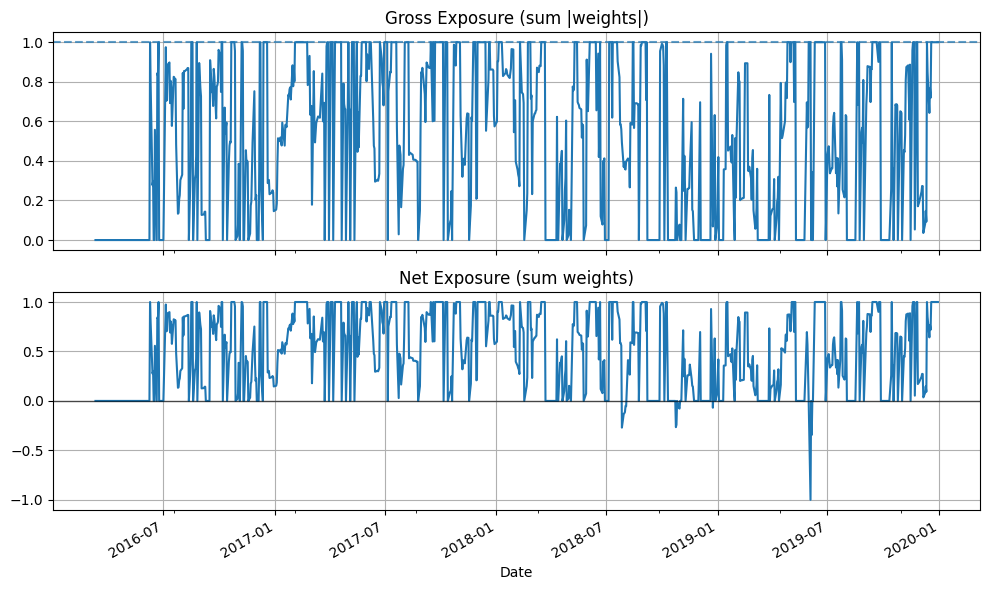

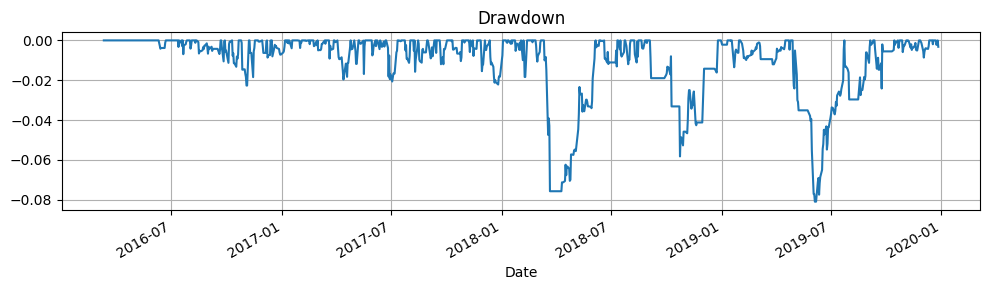


--- Summary ---
Strategy CAGR: 31.19%
Benchmark CAGR: 15.40%
Outperformance: 15.80% per year


In [5]:
start_date = "2010-01-01"
end_date   = "2019-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]
train_frac = 0.5

MA_WINDOW = 130
TRAIL_WINDOW = 10
TRAIL_PCT = 0.93
SHORT_THRESHOLD = 0.02
ATR_WIN = 14

COOLDOWN = 3
EPS = 0.005
MIN_HOLD = 5
WEEKLY = True
K_ATR = 2.5
GIVEBACK = 2.0
TIME_STOP = 60

TARGET_VOL = 0.10
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 63

# --- Run the backtest ---
results = run_backtest(
    start_date=start_date, end_date=end_date, stock_list=stock_list, train_frac=train_frac,
    ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
    short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
    cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD, weekly_exec=WEEKLY,
    k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
    target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
    initial_capital=500_000.0, compare_spy=True, tag="final"
)

print(results["portfolio_metrics"])

plot_vs_benchmark(results); plot_exposure(results); plot_drawdown(results)

print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

## 3. Strategy Optimisation

1. Describe key performance metrics & why we decided to use them
2. Describe how the strategy was optimised based on these metrics / what we improved on from mid-term

## 4. Strategy Visualisation & Evaluation

Evaluate how the final optimised strategy performs, with the help of various visualisations.

### 4.1 Performance Metrics

In [ ]:
print(results["portfolio_metrics"])

### 4.2 Performance vs Benchmark

In [ ]:
plot_vs_benchmark(results)

### 4.3 Portfolio Exposure

In [ ]:
plot_exposure(results)

### 4.4 Portfolio Drawdown

In [ ]:
plot_drawdown(results)

### 4.5 Summary

In [ ]:
print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

# minimal logging (saved to /storage/logs/)
log_dir = "./storage/logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "run_backtest.log"),
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logging.info(
    f"Backtest completed | Period: {start_date} → {end_date} | "
    f"Universe: {stock_list} | Metrics: {results['portfolio_metrics']}"
)
print("Logged to storage/logs/run_backtest.log")

## 5. Final Notebook Cell (Graders edit here)

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] Train period: 2012-05-18 00:00:00 → 2017-09-15 00:00:00 (1341 days)
[NOTIFY] Test  period: 2017-09-18 00:00:00 → 2019-12-30 00:00:00 (575 days)
[NOTIFY] Saved OOS returns → /Users/Student/Desktop/is4226/is4226-final/storage/returns_oos.csv
[NOTIFY] Saved OOS trades  → /Users/Student/Desktop/is4226/is4226-final/storage/trades_oos.csv
{'CAGR': 0.2637209112548309, 'Sharpe': np.float64(2.6325965311657096), 'MaxDrawdown': -0.08101004372123644, 'Calmar': 3.255410059551635}


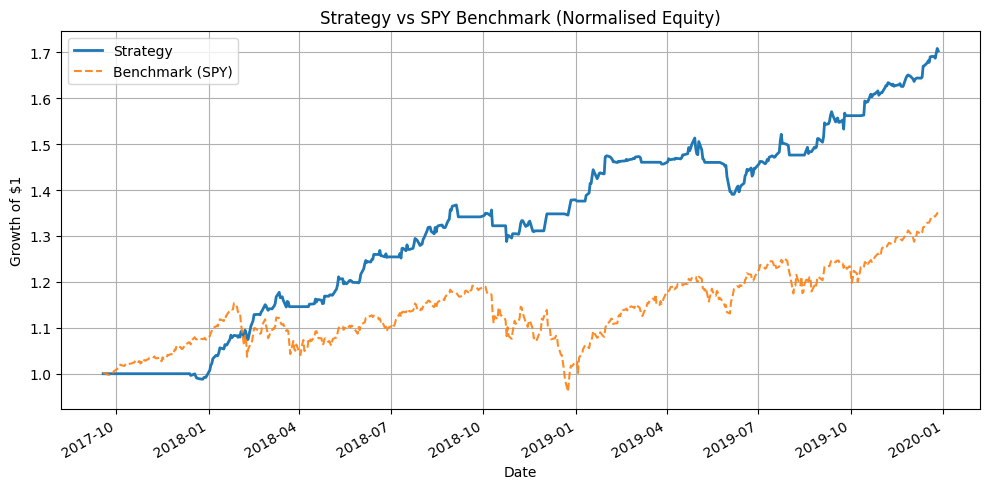

Gross cap respected (sum|weights| ≤ gross_cap).


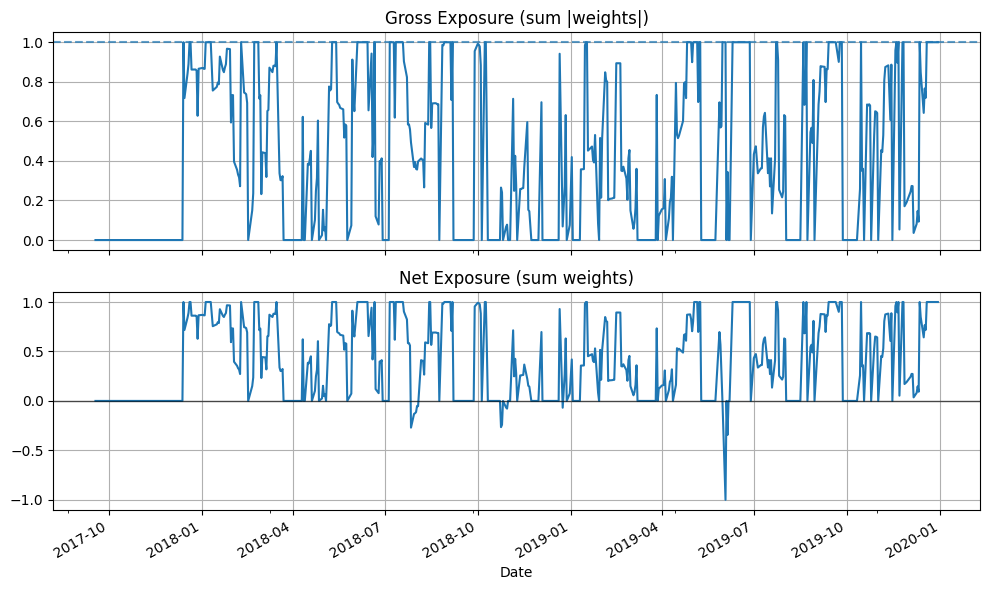

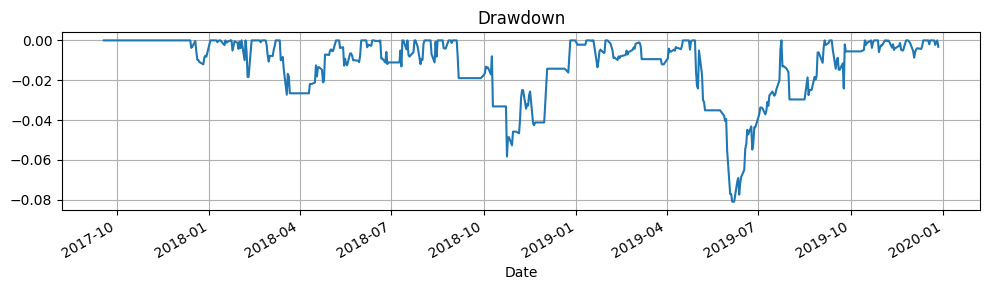


--- Summary ---
Strategy CAGR: 26.37%
Benchmark CAGR: 14.08%
Outperformance: 12.29% per year
Logged to storage/logs/run_backtest.log


In [ ]:
start_date = "2010-01-01"
end_date   = "2019-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]
train_frac = 0.7

MA_WINDOW = 130
TRAIL_WINDOW = 10
TRAIL_PCT = 0.93
SHORT_THRESHOLD = 0.02
ATR_WIN = 14

COOLDOWN = 3
EPS = 0.005
MIN_HOLD = 5
WEEKLY = True
K_ATR = 2.5
GIVEBACK = 2.0
TIME_STOP = 60

TARGET_VOL = 0.10
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 63

# --- Run the backtest ---
results = run_backtest(
    start_date=start_date, end_date=end_date, stock_list=stock_list,
    ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
    short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
    cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD, weekly_exec=WEEKLY,
    k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
    target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
    initial_capital=500_000.0, compare_spy=True, tag="final"
)

print(results["portfolio_metrics"])

plot_vs_benchmark(results); plot_exposure(results); plot_drawdown(results)

print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

# minimal logging (saved to /storage/logs/)
log_dir = "./storage/logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "run_backtest.log"),
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logging.info(
    f"Backtest completed | Period: {start_date} → {end_date} | "
    f"Universe: {stock_list} | Metrics: {results['portfolio_metrics']}"
)
print("Logged to storage/logs/run_backtest.log")
